In [ ]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# -----------------------
# Config / Hyperparams
# -----------------------
IMG_SIZE = (32, 32)   # resize to this
NUM_PIXELS = IMG_SIZE[0] * IMG_SIZE[1]
PLA_EPOCHS = 30
PLA_LR = 0.01
MLP_EPOCHS = 25
MLP_TRIALS = {
    'activations': ['relu', 'tanh'],
    'optimizers': ['sgd', 'adam'],
    'learning_rates': [0.001, 0.01],
    'batch_sizes': [32, 64]
}
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [ ]:
# -----------------------
# Utility functions
# -----------------------

def load_and_preprocess_image(path, img_size=IMG_SIZE):
    img = Image.open(path).convert('L')  # grayscale
    img = img.resize(img_size)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr


def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
# -----------------------
# Load dataset
# -----------------------
print('Loading CSV...')
df = pd.read_csv('/content/drive/MyDrive/ml-lab/english.csv')

df['image'] = df['image'].apply(lambda x: '/content/drive/MyDrive/ml-lab/' + str(x))

print('Loading images and preprocessing...')
X_list = []
for p in df['image'].tolist():
    X_list.append(load_and_preprocess_image(p))

X = np.stack(X_list, axis=0)  # shape: (N, H, W)
N = X.shape[0]
X_flat = X.reshape((N, -1))  # flattened for PLA and MLP

le = LabelEncoder()
y = le.fit_transform(df['label'])
classes = le.classes_
NUM_CLASSES = len(classes)
print(f'Loaded {N} samples, {NUM_CLASSES} classes')

# Train-test split
X_train_flat, X_test_flat, y_train, y_test, X_train_img, X_test_img = train_test_split(
    X_flat, y, X, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# For MLP (Keras) we'll use flattened inputs
input_dim = X_train_flat.shape[1]

# One-hot for MLP
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# For ROC, need binarized labels
y_test_binarized = label_binarize(y_test, classes=np.arange(NUM_CLASSES))

Loading CSV...
Loading images and preprocessing...
Loaded 3410 samples, 62 classes



Training Perceptron (PLA) - One-vs-Rest


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


PLA Test Accuracy: 0.1774, Precision: 0.2708, Recall: 0.1774, F1: 0.1576


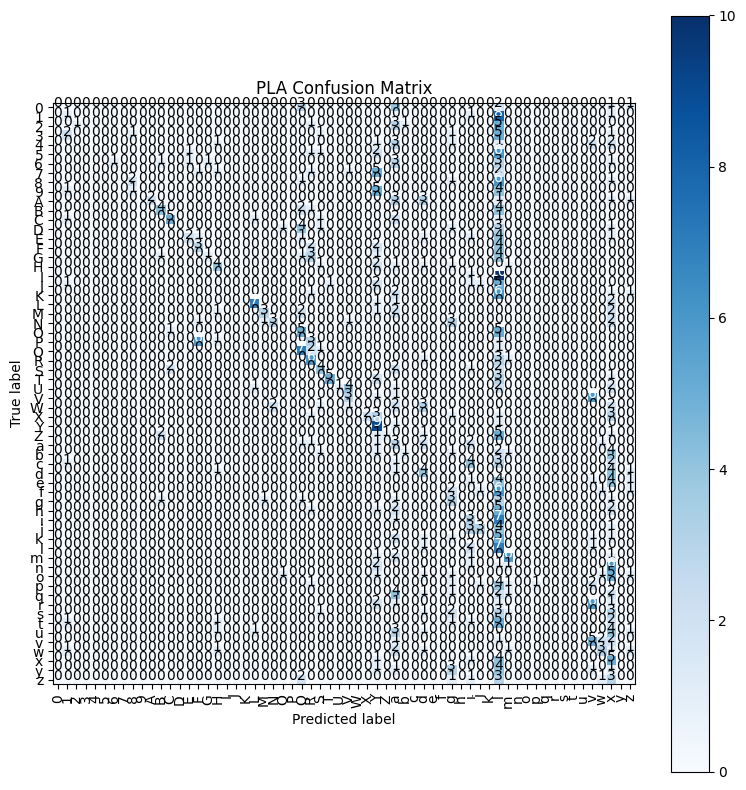

In [ ]:
# -----------------------
# Implement PLA (one-vs-rest)
# -----------------------
print('\nTraining Perceptron (PLA) - One-vs-Rest')

class OneVsRestPLA:
    def __init__(self, n_classes, n_features, lr=0.01):
        self.n_classes = n_classes
        self.n_features = n_features
        self.lr = lr
        # weight matrix: (n_classes, n_features + 1) - last column for bias
        self.W = np.zeros((n_classes, n_features + 1), dtype=np.float32)

    def _augment(self, X):
        # add bias term as 1
        return np.hstack([X, np.ones((X.shape[0], 1), dtype=X.dtype)])

    def fit(self, X, y, epochs=10):
        X_aug = self._augment(X)
        for ep in range(epochs):
            # simple SGD pass
            indices = np.arange(X_aug.shape[0])
            np.random.shuffle(indices)
            for i in indices:
                xi = X_aug[i]
                yi = y[i]
                # for each class k: desired t = 1 if yi==k else -1
                for k in range(self.n_classes):
                    t = 1 if yi == k else -1
                    score = np.dot(self.W[k], xi)
                    yhat = 1 if score >= 0 else -1
                    if t != yhat:
                        # update
                        self.W[k] += self.lr * (t - yhat) * xi

    def predict(self, X):
        X_aug = self._augment(X)
        scores = np.dot(X_aug, self.W.T)  # shape (N, n_classes)
        preds = np.argmax(scores, axis=1)
        return preds

# Train PLA
pla = OneVsRestPLA(n_classes=NUM_CLASSES, n_features=input_dim, lr=PLA_LR)
pla.fit(X_train_flat, y_train, epochs=PLA_EPOCHS)

# Evaluate PLA
y_pred_pla = pla.predict(X_test_flat)
acc_pla = accuracy_score(y_test, y_pred_pla)
prec_pla, rec_pla, f1_pla, _ = precision_recall_fscore_support(y_test, y_pred_pla, average='macro')
print(f'PLA Test Accuracy: {acc_pla:.4f}, Precision: {prec_pla:.4f}, Recall: {rec_pla:.4f}, F1: {f1_pla:.4f}')

cm_pla = confusion_matrix(y_test, y_pred_pla)
plot_confusion_matrix(cm_pla, classes, title='PLA Confusion Matrix')


Hyperparameter tuning MLP (grid search over small set)
-- Trial: act=relu, opt=sgd, lr=0.001, batch=32
   val_acc=0.0561
-- Trial: act=relu, opt=sgd, lr=0.001, batch=64
   val_acc=0.0293
-- Trial: act=relu, opt=sgd, lr=0.01, batch=32
   val_acc=0.2146
-- Trial: act=relu, opt=sgd, lr=0.01, batch=64
   val_acc=0.1024
-- Trial: act=relu, opt=adam, lr=0.001, batch=32
   val_acc=0.2878
-- Trial: act=relu, opt=adam, lr=0.001, batch=64
   val_acc=0.2512
-- Trial: act=relu, opt=adam, lr=0.01, batch=32
   val_acc=0.0024
-- Trial: act=relu, opt=adam, lr=0.01, batch=64
   val_acc=0.0098
-- Trial: act=tanh, opt=sgd, lr=0.001, batch=32
   val_acc=0.0585
-- Trial: act=tanh, opt=sgd, lr=0.001, batch=64
   val_acc=0.0220
-- Trial: act=tanh, opt=sgd, lr=0.01, batch=32
   val_acc=0.2512
-- Trial: act=tanh, opt=sgd, lr=0.01, batch=64
   val_acc=0.1317
-- Trial: act=tanh, opt=adam, lr=0.001, batch=32
   val_acc=0.0707
-- Trial: act=tanh, opt=adam, lr=0.001, batch=64
   val_acc=0.2171
-- Trial: act=tanh, 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


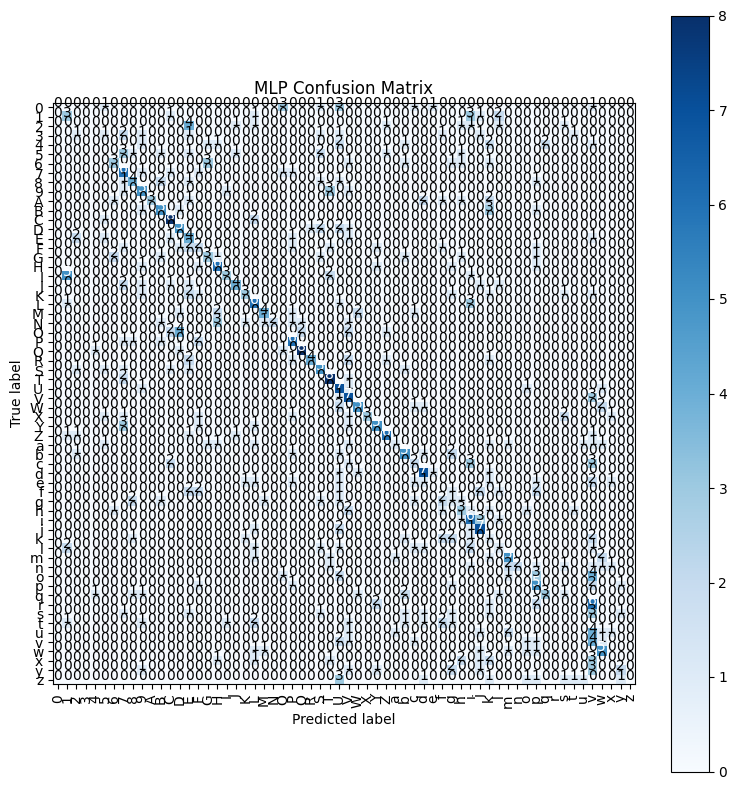

In [ ]:
# -----------------------
# MLP: tuning and training (Keras)
# -----------------------
print('\nHyperparameter tuning MLP (grid search over small set)')

best_val_acc = -1.0
best_history = None
best_model = None
best_config = None

for activation in MLP_TRIALS['activations']:
    for opt_name in MLP_TRIALS['optimizers']:
        for lr in MLP_TRIALS['learning_rates']:
            for batch_size in MLP_TRIALS['batch_sizes']:
                print(f'-- Trial: act={activation}, opt={opt_name}, lr={lr}, batch={batch_size}')

                # Build model
                model = keras.Sequential([
                    layers.Input(shape=(input_dim,)),
                    layers.Dense(512, activation=activation),
                    layers.Dense(256, activation=activation),
                    layers.Dense(NUM_CLASSES, activation='softmax')
                ])

                if opt_name == 'sgd':
                    optimizer = keras.optimizers.SGD(learning_rate=lr)
                elif opt_name == 'adam':
                    optimizer = keras.optimizers.Adam(learning_rate=lr)
                else:
                    raise ValueError('Unknown optimizer')

                model.compile(optimizer=optimizer,
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

                history = model.fit(X_train_flat, y_train_ohe,
                                    validation_split=0.15,
                                    epochs=MLP_EPOCHS,
                                    batch_size=batch_size,
                                    verbose=0)

                val_acc = history.history['val_accuracy'][-1]
                print(f'   val_acc={val_acc:.4f}')

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_history = history
                    best_model = model
                    best_config = dict(activation=activation, optimizer=opt_name, lr=lr, batch_size=batch_size)

print('\nBest MLP config:', best_config)
print('Best validation accuracy:', best_val_acc)

# Evaluate best model on test set
print('\nEvaluating best MLP on test set...')
mlp_preds_prob = best_model.predict(X_test_flat)
mlp_preds = np.argmax(mlp_preds_prob, axis=1)
acc_mlp = accuracy_score(y_test, mlp_preds)
prec_mlp, rec_mlp, f1_mlp, _ = precision_recall_fscore_support(y_test, mlp_preds, average='macro')
print(f'MLP Test Accuracy: {acc_mlp:.4f}, Precision: {prec_mlp:.4f}, Recall: {rec_mlp:.4f}, F1: {f1_mlp:.4f}')

cm_mlp = confusion_matrix(y_test, mlp_preds)
plot_confusion_matrix(cm_mlp, classes, title='MLP Confusion Matrix')


Plotting ROC curves (micro & macro) for MLP)


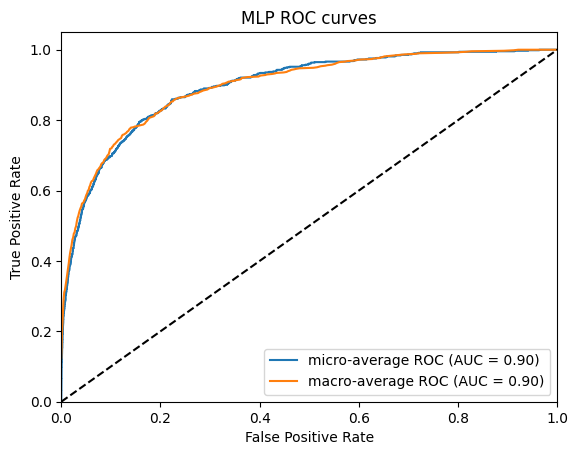

In [ ]:
# -----------------------
# ROC Curves (micro & macro)
# -----------------------
print('\nPlotting ROC curves (micro & macro) for MLP)')

# For PLA we only have hard labels; to plot ROC we'd need scores. We can compute score matrix via W dot x.
# Compute score matrix for PLA
X_test_aug = np.hstack([X_test_flat, np.ones((X_test_flat.shape[0], 1))])
pla_scores = np.dot(X_test_aug, pla.W.T)  # shape (N, n_classes)

# For MLP, we have mlp_preds_prob

# Binarize y_test
y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))

# Compute ROC per class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], mlp_preds_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except ValueError:
        # When a class is not present in y_test, skip
        fpr[i], tpr[i], roc_auc[i] = None, None, None

# micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), mlp_preds_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average: aggregate all fpr points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES) if fpr[i] is not None]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    if fpr[i] is not None:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= NUM_CLASSES
roc_auc_macro = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot(fpr_micro, tpr_micro, label=f'micro-average ROC (AUC = {roc_auc_micro:.2f})')
plt.plot(all_fpr, mean_tpr, label=f'macro-average ROC (AUC = {roc_auc_macro:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC curves')
plt.legend(loc='lower right')
plt.show()


Plotting training curves for best MLP...


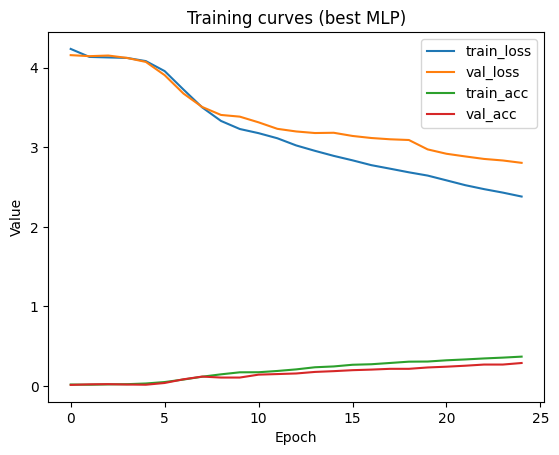

In [ ]:
# -----------------------
# Training curves (best MLP)
# -----------------------
print('\nPlotting training curves for best MLP...')
plt.figure()
plt.plot(best_history.history['loss'], label='train_loss')
plt.plot(best_history.history['val_loss'], label='val_loss')
plt.plot(best_history.history['accuracy'], label='train_acc')
plt.plot(best_history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training curves (best MLP)')
plt.legend()
plt.show()

In [ ]:
# -----------------------
# Summarize & Print chosen hyperparameters
# -----------------------
print('\nFINAL SUMMARY:')
print('PLA:')
print(f'  epochs={PLA_EPOCHS}, learning_rate={PLA_LR}')
print(f'  Test accuracy={acc_pla:.4f}, Precision={prec_pla:.4f}, Recall={rec_pla:.4f}, F1={f1_pla:.4f}')
print('\nMLP (best):')
print(f'  config={best_config}')
print(f'  epochs={MLP_EPOCHS}')
print(f'  Test accuracy={acc_mlp:.4f}, Precision={prec_mlp:.4f}, Recall={rec_mlp:.4f}, F1={f1_mlp:.4f}')


FINAL SUMMARY:
PLA:
  epochs=30, learning_rate=0.01
  Test accuracy=0.1774, Precision=0.2708, Recall=0.1774, F1=0.1576

MLP (best):
  config={'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001, 'batch_size': 32}
  epochs=25
  Test accuracy=0.2977, Precision=0.3207, Recall=0.2977, F1=0.2752
